<a href="https://colab.research.google.com/github/Mobbu02/Julia/blob/main/Kopie_se%C5%A1itu_100_Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dataset - describe + load + split

**Datasets consists of:**
- **CustomerID**
- **Genre**
- **Age**
- **Annual Income (k$)**: In thousands of dollars.
- **Spending SCore (1-100)**: Score reflecting customer spending behavior.

### Goal
Cluster customers based on their attributes and behavior.


In [49]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import pandas as pd

# Load PD
df = pd.read_csv("/content/drive/MyDrive/Mall_Customers.csv")
print(f"Shape of data: {df.shape[0]} rows and {df.shape[1]} columns.", "\n")
print(df.head(), "\n")
df.info()

Shape of data: 200 rows and 5 columns. 

   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


## Visualization of data

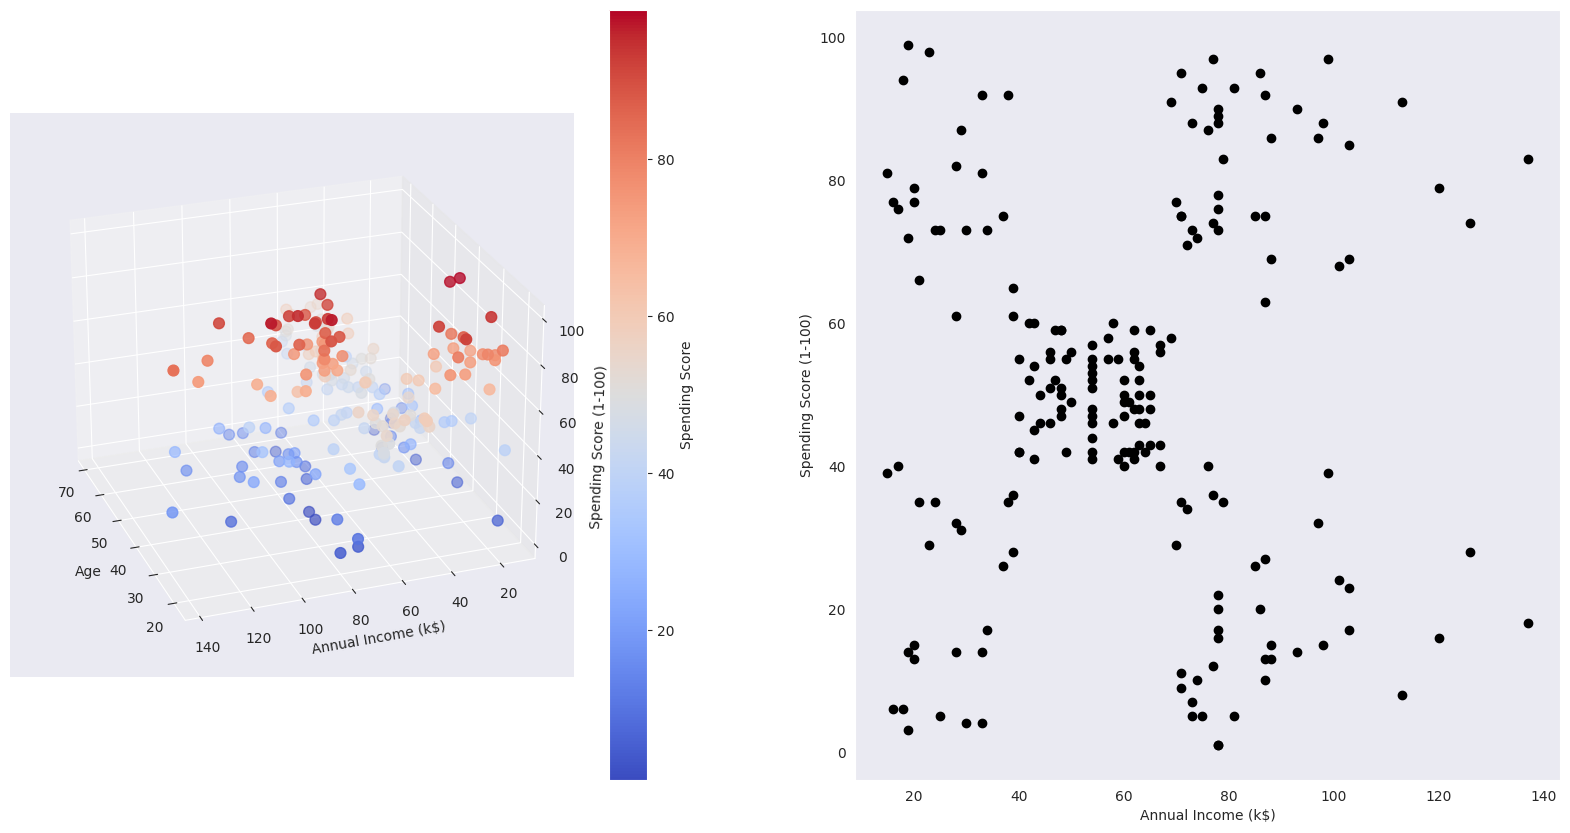

In [71]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# 3D visualisation of data
sns.set_style("dark")
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121, projection='3d')
scatter = ax.scatter(
    df.Age, df["Annual Income (k$)"], df["Spending Score (1-100)"],
    c=df["Spending Score (1-100)"], cmap='coolwarm', marker='o', s=60
)
ax.view_init(25, 160)
plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")
ax.set_zlabel('Spending Score (1-100)')
cbar = plt.colorbar(scatter)
cbar.set_label('Spending Score')

ax = fig.add_subplot(122)
scatter_m = ax.scatter(
    df["Annual Income (k$)"], df["Spending Score (1-100)"], color='black' ,marker='o')
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")

plt.show()

## Extraction of features


In [84]:
# Extraction of relevant features - Annual Income and Spending Score
features = df[["Annual Income (k$)", "Spending Score (1-100)"]]
features3 = df[["Age", "Annual Income (k$)", "Spending Score (1-100)"]]

# Transform dataframe into a numpy array
dat_ar = features.to_numpy()
dat_ar3 = features3.to_numpy()
print(f"First 5 data points: \n {dat_ar[:5]}")

# Split data, no labels
X_train, X_test = train_test_split(dat_ar, test_size=0.2, random_state=42)

X_train3, X_test3 = train_test_split(dat_ar3, test_size=0.2, random_state=42)

First 5 data points: 
 [[15 39]
 [15 81]
 [16  6]
 [16 77]
 [17 40]]


### K-Means Clustering class




In [145]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython import display

np.random.seed(42)

def euclidean_distance(x1, x2):
  return np.sqrt(np.sum((x1 - x2) ** 2))


class KMeans:
  def __init__(self, K=5, max_iters=100, plot_steps=False, plot_delay=1, two_d = True):
    self.K = K
    self.iter = 0
    self.max_iters = max_iters
    self.plot_steps = plot_steps
    self.plot_delay = plot_delay
    self.two_d = two_d
    self.rotation_counter = 0

    # list of sample indices for each cluster
    self.clusters = [[] for _ in range(self.K)]
    # the centers (mean feature vector) for each cluster
    self.centroids = []

  def predict(self, X):
    self.X = X
    self.n_samples, self.n_features = X.shape

    # initialize
    random_sample_idxs = np.random.choice(self.n_samples, self.K, replace=False)
    self.centroids = [self.X[idx] for idx in random_sample_idxs]

    # Optimize clusters
    for _ in range(self.max_iters):
      self.iter += 1
      # Assign samples to closest centroids (create clusters)
      self.clusters = self._create_clusters(self.centroids)

      # Calculate new centroids from the clusters
      centroids_old = self.centroids
      self.centroids = self._get_centroids(self.clusters)

      # check if clusters have changed
      if self._is_converged(centroids_old, self.centroids):
        break

      if self.plot_steps: # Added
        if self.two_d:
          self.plot()
        else:
          self.plot3d()

    # Classify samples as the index of their clusters
    return self._get_cluster_labels(self.clusters)

  def _get_cluster_labels(self, clusters):
    # each sample will get the label of the cluster it was assigned to
    labels = np.empty(self.n_samples)

    for cluster_idx, cluster in enumerate(clusters):
      for sample_index in cluster:
        labels[sample_index] = cluster_idx
    return labels

  def _create_clusters(self, centroids):
    # Assign the samples to the closest centroids to create clusters
    clusters = [[] for _ in range(self.K)]
    for idx, sample in enumerate(self.X):
      centroid_idx = self._closest_centroid(sample, centroids)
      clusters[centroid_idx].append(idx)
    return clusters

  def _closest_centroid(self, sample, centroids):
    # distance of the current sample to each centroid
    distances = [euclidean_distance(sample, point) for point in centroids]
    closest_index = np.argmin(distances)
    return closest_index

  def _get_centroids(self, clusters):
    # assign mean value of clusters to centroids
    centroids = np.zeros((self.K, self.n_features))
    for cluster_idx, cluster in enumerate(clusters):
      cluster_mean = np.mean(self.X[cluster], axis=0)
      centroids[cluster_idx] = cluster_mean
    return centroids

  def _is_converged(self, centroids_old, centroids):
    # distances between each old and new centroids, fol all centroids
    distances = [
                 euclidean_distance(centroids_old[i], centroids[i]) for i in range(self.K)
                 ]
    return sum(distances) == 0

  def _inertia(self): # Added
    inertia = 0
    for cluster_idx, cluster in enumerate(self.clusters):
      centroid = self.centroids[cluster_idx]
      for sample_index in cluster:
        sample = self.X[sample_index]
        inertia += euclidean_distance(sample, centroid) ** 2
    return inertia

  def plot(self):
    fig, ax = plt.subplots(figsize=(12, 8))

    for i, index in enumerate(self.clusters):
      point = self.X[index].T
      ax.scatter(*point)

    for point in self.centroids:
      ax.scatter(*point, marker="x", color="black", linewidth=2)
    plt.title(f'Iteration = {self.iter}')
    display.clear_output(wait=True)
    display.display(plt.show())
    time.sleep(self.plot_delay)
    plt.close()

  def plot3d(self): # Added
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Labels
    train_labels = self._get_cluster_labels(self.clusters)

    for i in range(self.K):
        cluster_mask = train_labels == i
        if np.any(cluster_mask):  # Check if there are any samples in the cluster
            cluster_samples = self.X[cluster_mask, :]
            ax.scatter(cluster_samples[:, 0], cluster_samples[:, 1], cluster_samples[:, 2], label=f'Cluster {i+1}')

    ax.scatter(self.centroids[:, 0], self.centroids[:, 1], self.centroids[:, 2], marker='X', c='black', s=200, label='Centroids')
    ax.view_init(45-self.rotation_counter*5, 160- self.rotation_counter*5)
    self.rotation_counter +=1
    ax.set_xlabel("Age")
    ax.set_ylabel("Annual Income (k$)")
    ax.set_zlabel('Spending Score (1-100)')
    ax.legend()
    plt.title(f'Iteration = {self.iter}')
    display.clear_output(wait=True)
    display.display(plt.show())
    time.sleep(self.plot_delay)
    plt.close()


## Elbow method

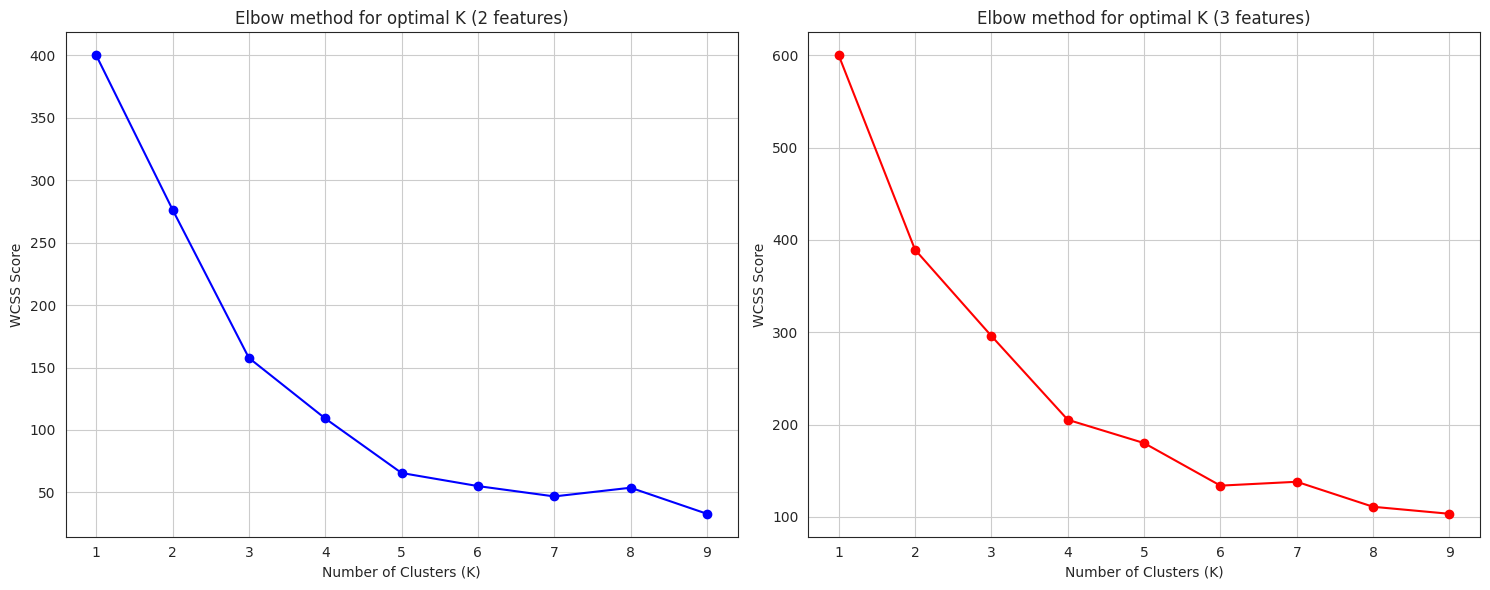

In [135]:
from sklearn.preprocessing import StandardScaler

# Standardizing the data
scaler = StandardScaler()
dat_scaled = scaler.fit_transform(dat_ar)
dat_scaled3 = scaler.fit_transform(dat_ar3)

# List for scores
elbow_scores = []
elbow_scores3 = []

# Calculate inertia for each of the clusters
for e in range(1,10):
  kmeans = KMeans(K = e, max_iters = 100)
  kmeans3 = KMeans(K = e, max_iters = 100)
  kmeans.predict(dat_scaled)
  kmeans3.predict(dat_scaled3)
  elbow_scores.append(kmeans._inertia())
  elbow_scores3.append(kmeans3._inertia())



# Plot the Elbow graph with subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot for elbow_scores
axes[0].plot(range(1, 10), elbow_scores, marker='o', linestyle='-', color='b')
axes[0].set_title('Elbow method for optimal K (2 features)')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('WCSS Score')
axes[0].grid()

# Plot for elbow_scores3
axes[1].plot(range(1, 10), elbow_scores3, marker='o', linestyle='-', color='r')
axes[1].set_title('Elbow method for optimal K (3 features)')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('WCSS Score')
axes[1].grid()

plt.tight_layout()
plt.show()


### Training

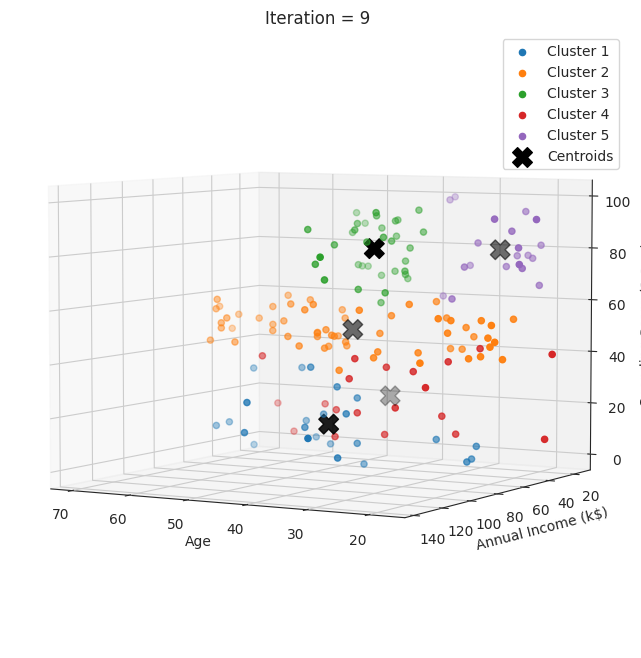

None

In [146]:
kmeans = KMeans(K=5, max_iters=100, plot_steps=True, plot_delay=0.25)
train_labels = kmeans.predict(X_train)

kmeans3 = KMeans(K=5, max_iters=100, plot_steps=True, plot_delay=0.25, two_d=False)
train_labels = kmeans3.predict(X_train3)

## Discussion

Succesful segmentation of the customers based on the annual income and spending.

Succesful segmentation of the customers based on their age, annual income and spending.

The Elbow method for 2 classes showed me the optimal number of clusters - 5. This is what I expected from the visualization of the data at the start.

The Elbow method for 3 classes showed that 5 clusters are optimal too.

Hierarchical clustering can be used too.

I have tried several methods on how to display graphs. But I still find that plotting in Julia is better.